In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import math
import json
import os
from pathlib import Path
from safetensors.torch import load_file
from huggingface_hub import hf_hub_download, snapshot_download

### Gemma 3 Model İncelemesi ###
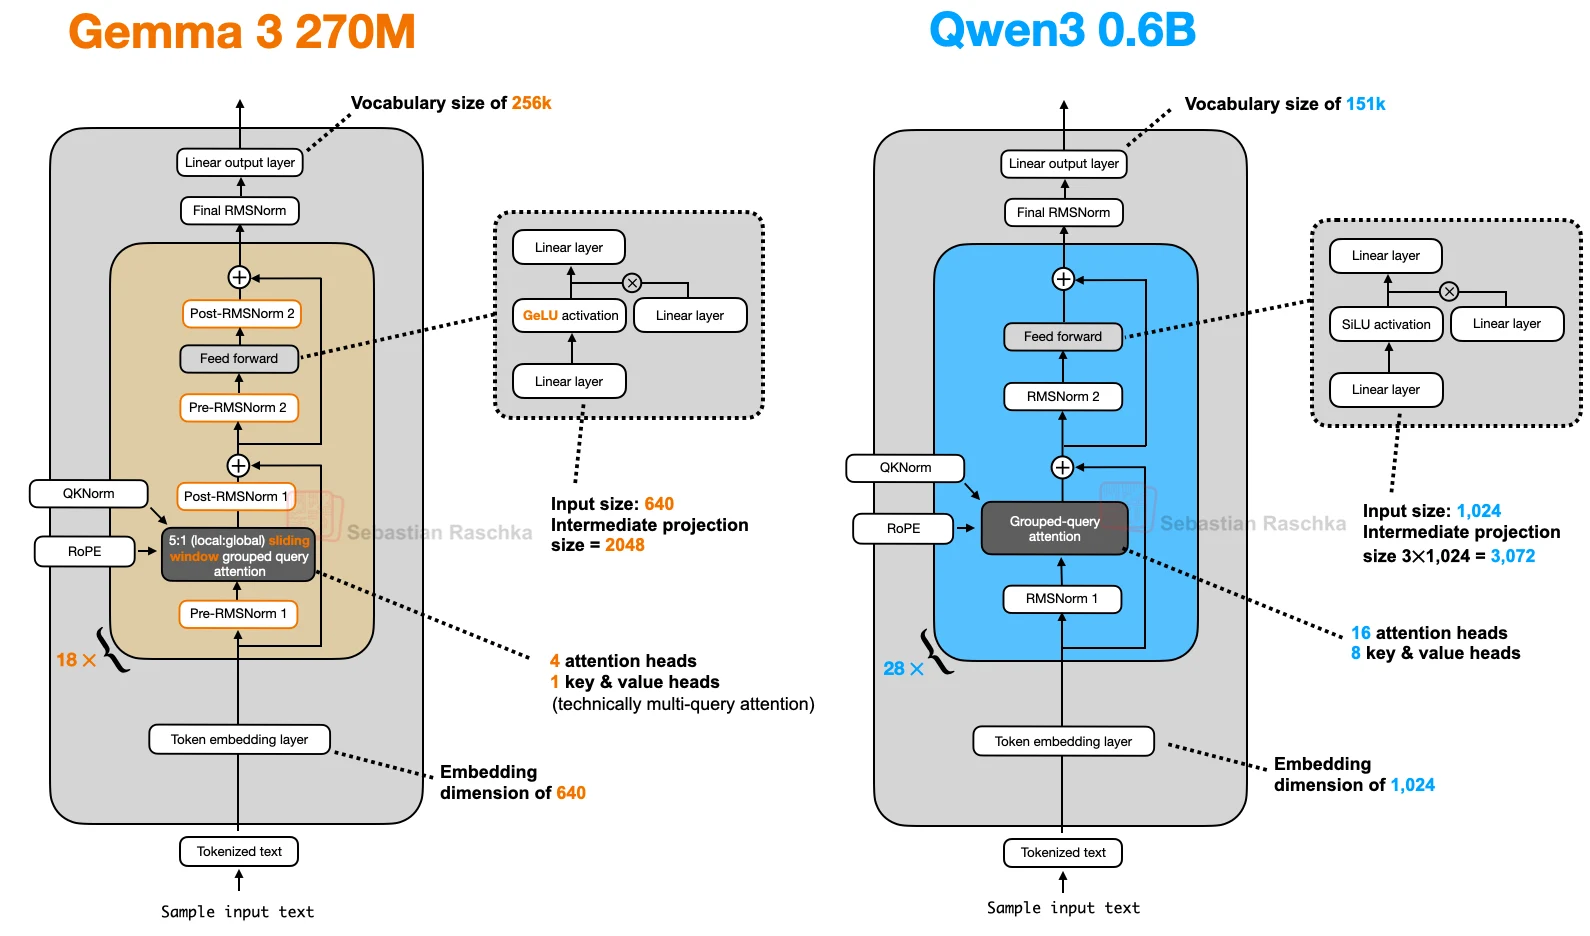
[Kaynak - Sebastian Raschka]

Görüldüğü üzere Gemma modellerinde RMSNorm, Residual yapısı, RoPE (Rotary Positional Encoding), FeedForward ve Grouped Query Attention mekanizmaları görülmektedir. Bu nedenle kendisinden önceki modellerden farklılık göstermez. Gemma modellerinin farklılık gösterdiği yerlerden bazıları Causal Maskeleme kısmındadır. Sıradan Causal maskeleme yerine sliding maskeleme kullanılır. 

Normalizasyon kısmı ile başlayalım. Klasik transformer modellerinde normalizasyon işlemi ortalama ve varyans yardımıyla bulunur ve
(x - mean) / var şeklinde formül uygulanır. Bu da  veri dağılımını ortalaması 0'a varyansı 1'e yakın hale getirmeye çalışır ve Gaussian dağılıma benzetir. Ancak bazı modellerde bu yaklaşım yerine RMSNormalization yaklaşımı izlenmektedir. Burada ortalamaların karelerinin karekökü alınır. Ayrıca RMSNorm yöntemi klasik Layer Normalization yönteminden daha az işlem ve parametre içermektedir. Büyük modellerde ortalama çıkarma işlemi küçük farkların büyümesine de neden olabileceğinden RMSNorm yönteminde ortalama çıkarılmaz.

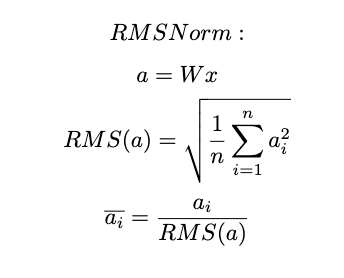

In [2]:
class RMSNorm(nn.Module):
  def __init__(self, dim:int, eps:float=1e-6, dtype = None) -> None:
    super().__init__()
    self.eps = eps
    self.gamma = nn.Parameter(torch.ones(dim))

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    inp_dtype = x.dtype
    x_f = x.float()
    ms = x_f.pow(2).mean(dim=-1, keepdim = True)
    x_norm = x_f / torch.sqrt(ms + self.eps)
    # Gemma modelinde normalden farklı olarak self.gamma'ya 1 ekleriz.
    out = (self.gamma.float() + 1.0) * x_norm
    return out.to(inp_dtype)

Gelelim Feed Forward mimarisine. Bazı modellerde bu mimari MoE (Mixture of Experts) yapısıyla geliştirilmiş olsa da bu modelde MoE yapısı kullanılmadı. FeedForward yapısı klasik olarak 3 linear katmandan ve 1 aktivasyon fonksiyonundan oluşup modele göre aktivasyon fonksiyonu farklılık gösterebilir.

In [3]:
class FeedForward(nn.Module):
  def __init__(self, cfg:dict) -> None:
    super().__init__()
    self.fc1 = nn.Linear(cfg['emb_dim'], cfg['hidden_dim'], dtype = cfg['dtype'], bias = False)
    self.fc2 = nn.Linear(cfg['emb_dim'], cfg['hidden_dim'], dtype = cfg['dtype'], bias = False)
    self.fc3 = nn.Linear(cfg['hidden_dim'], cfg['emb_dim'], dtype = cfg['dtype'], bias = False)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    x_fc1 = self.fc1(x)
    x_fc2 = self.fc2(x)
    # Genel yaklaşımda aktivasyon fonksiyonu olarak SiLU kullanılır.
    x = F.gelu(x_fc1, approximate = 'tanh') * x_fc2
    x = self.fc3(x)
    return x

## Rope Embedding ve Embedding İncelemesi ##

Gelişmiş modellerde geleneksel transformerlardan farklı olarak Embedding vektörü reel olmayan düzlemden Euler formülü aracılığıyla türetilir. Klasik Transformer modellerinde, kelime embedding’lerine ek olarak bir pozisyon (sıra) embedding’i oluşturulur ve bu iki vektör toplanarak modele pozisyon bilgisi kazandırılır. Ancak bu yaklaşım mutlak (absolute) konum bilgisi içerdiğinden, giriş dizisinin uzunluğu context_length parametresini aştığında pozisyon bilgisinin genellenebilirliği zayıflar. Bu sorunu aşmak için, gelişmiş modellerde sinüs ve kosinüs fonksiyonlarının periyodik yapısından yararlanan RoPE (Rotary Positional Embedding) yöntemi kullanılmaktadır.

## Absolute Ve Relative Positional Encoding Arasındaki Farklar ##

Absolute positional encoding ilgili tokenın cümledeki pozisyon bilgisini içereceğinden her seferinde bir tokenla uğraşır ancak relative positional encoding bu pozisyon bilgisinin yanı sıra iki token arasındaki mesafe bilgisini de içereceğinden dolayı her seferinde iki token ile uğraşır.

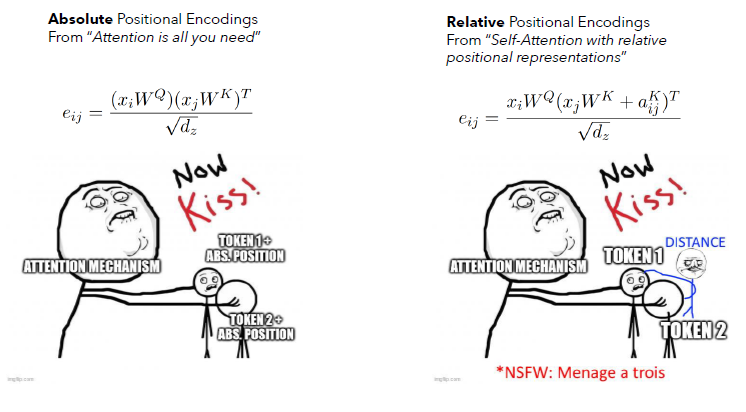

[Kaynak - Umar Jamil Coding LLaMA 2 From Scratch]

Yukarıdaki şekilde de görüldüğü üzere geleneksel transformer mimarisinde formülümüz Q @ K.T / sqrt(dim) şeklinde iken relative positional encodingte Q @ (K + dist_matrix).T / sqrt(dim) şekline gelmiştir. Bu da vektörlerin sıra bilgisiyle değil birbirleri arasındaki mesafe ile tutulduğunu gösterir. Bu yaklaşım zero-shot'ta yüksek performans gösterir.
Rotary Positional Encoding paperının yazarları işlemleri inner product ile yapmıştır. Bu da dot productın reel olmayan düzlemdeki hali gibi düşünülebilir.

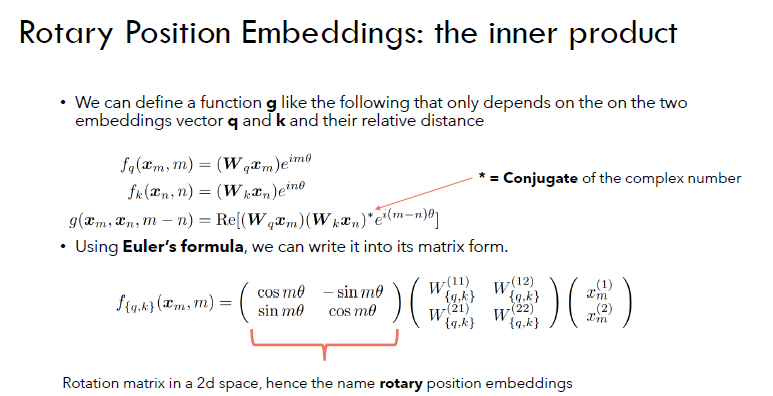

[Kaynak - Umar Jamil]

Yukarıdaki şekilde de görüldüğü üzere key ve query matrisleri mesafeleri de içeren bir g fonksiyonuna çevrildiğinde ve Euler formülü de kullanıldığında kosinüs ve sinüs elde ederiz. Buradaki kosinüs ve sinüslü matris de döndürme matrisi (rotation matrix)tir. Ancak bu işlem 2 boyutlu düzlemdedir. Bunu çok boyutlu düzleme aktarırsak aşağıdaki şekildeki gibi bir matris elde ederiz.

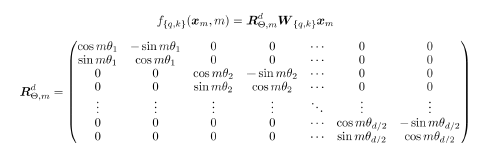

Burada theta parametresi yazarların belirttiği üzere 10000 ^ (-2(i-1) / d) formülü ile bulunur.

Yukarıdaki resimdeki sparse matris boş yere yer kaplayacağı ve bellekte ziyana yol açacağı için yukarıdaki işlemi şuna dönüştürebiliriz:

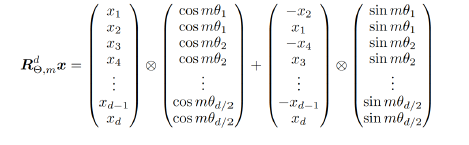


Küçük bir örneklem kümesi üzerinde RoPe formülünün Euler formülü ile ispatı

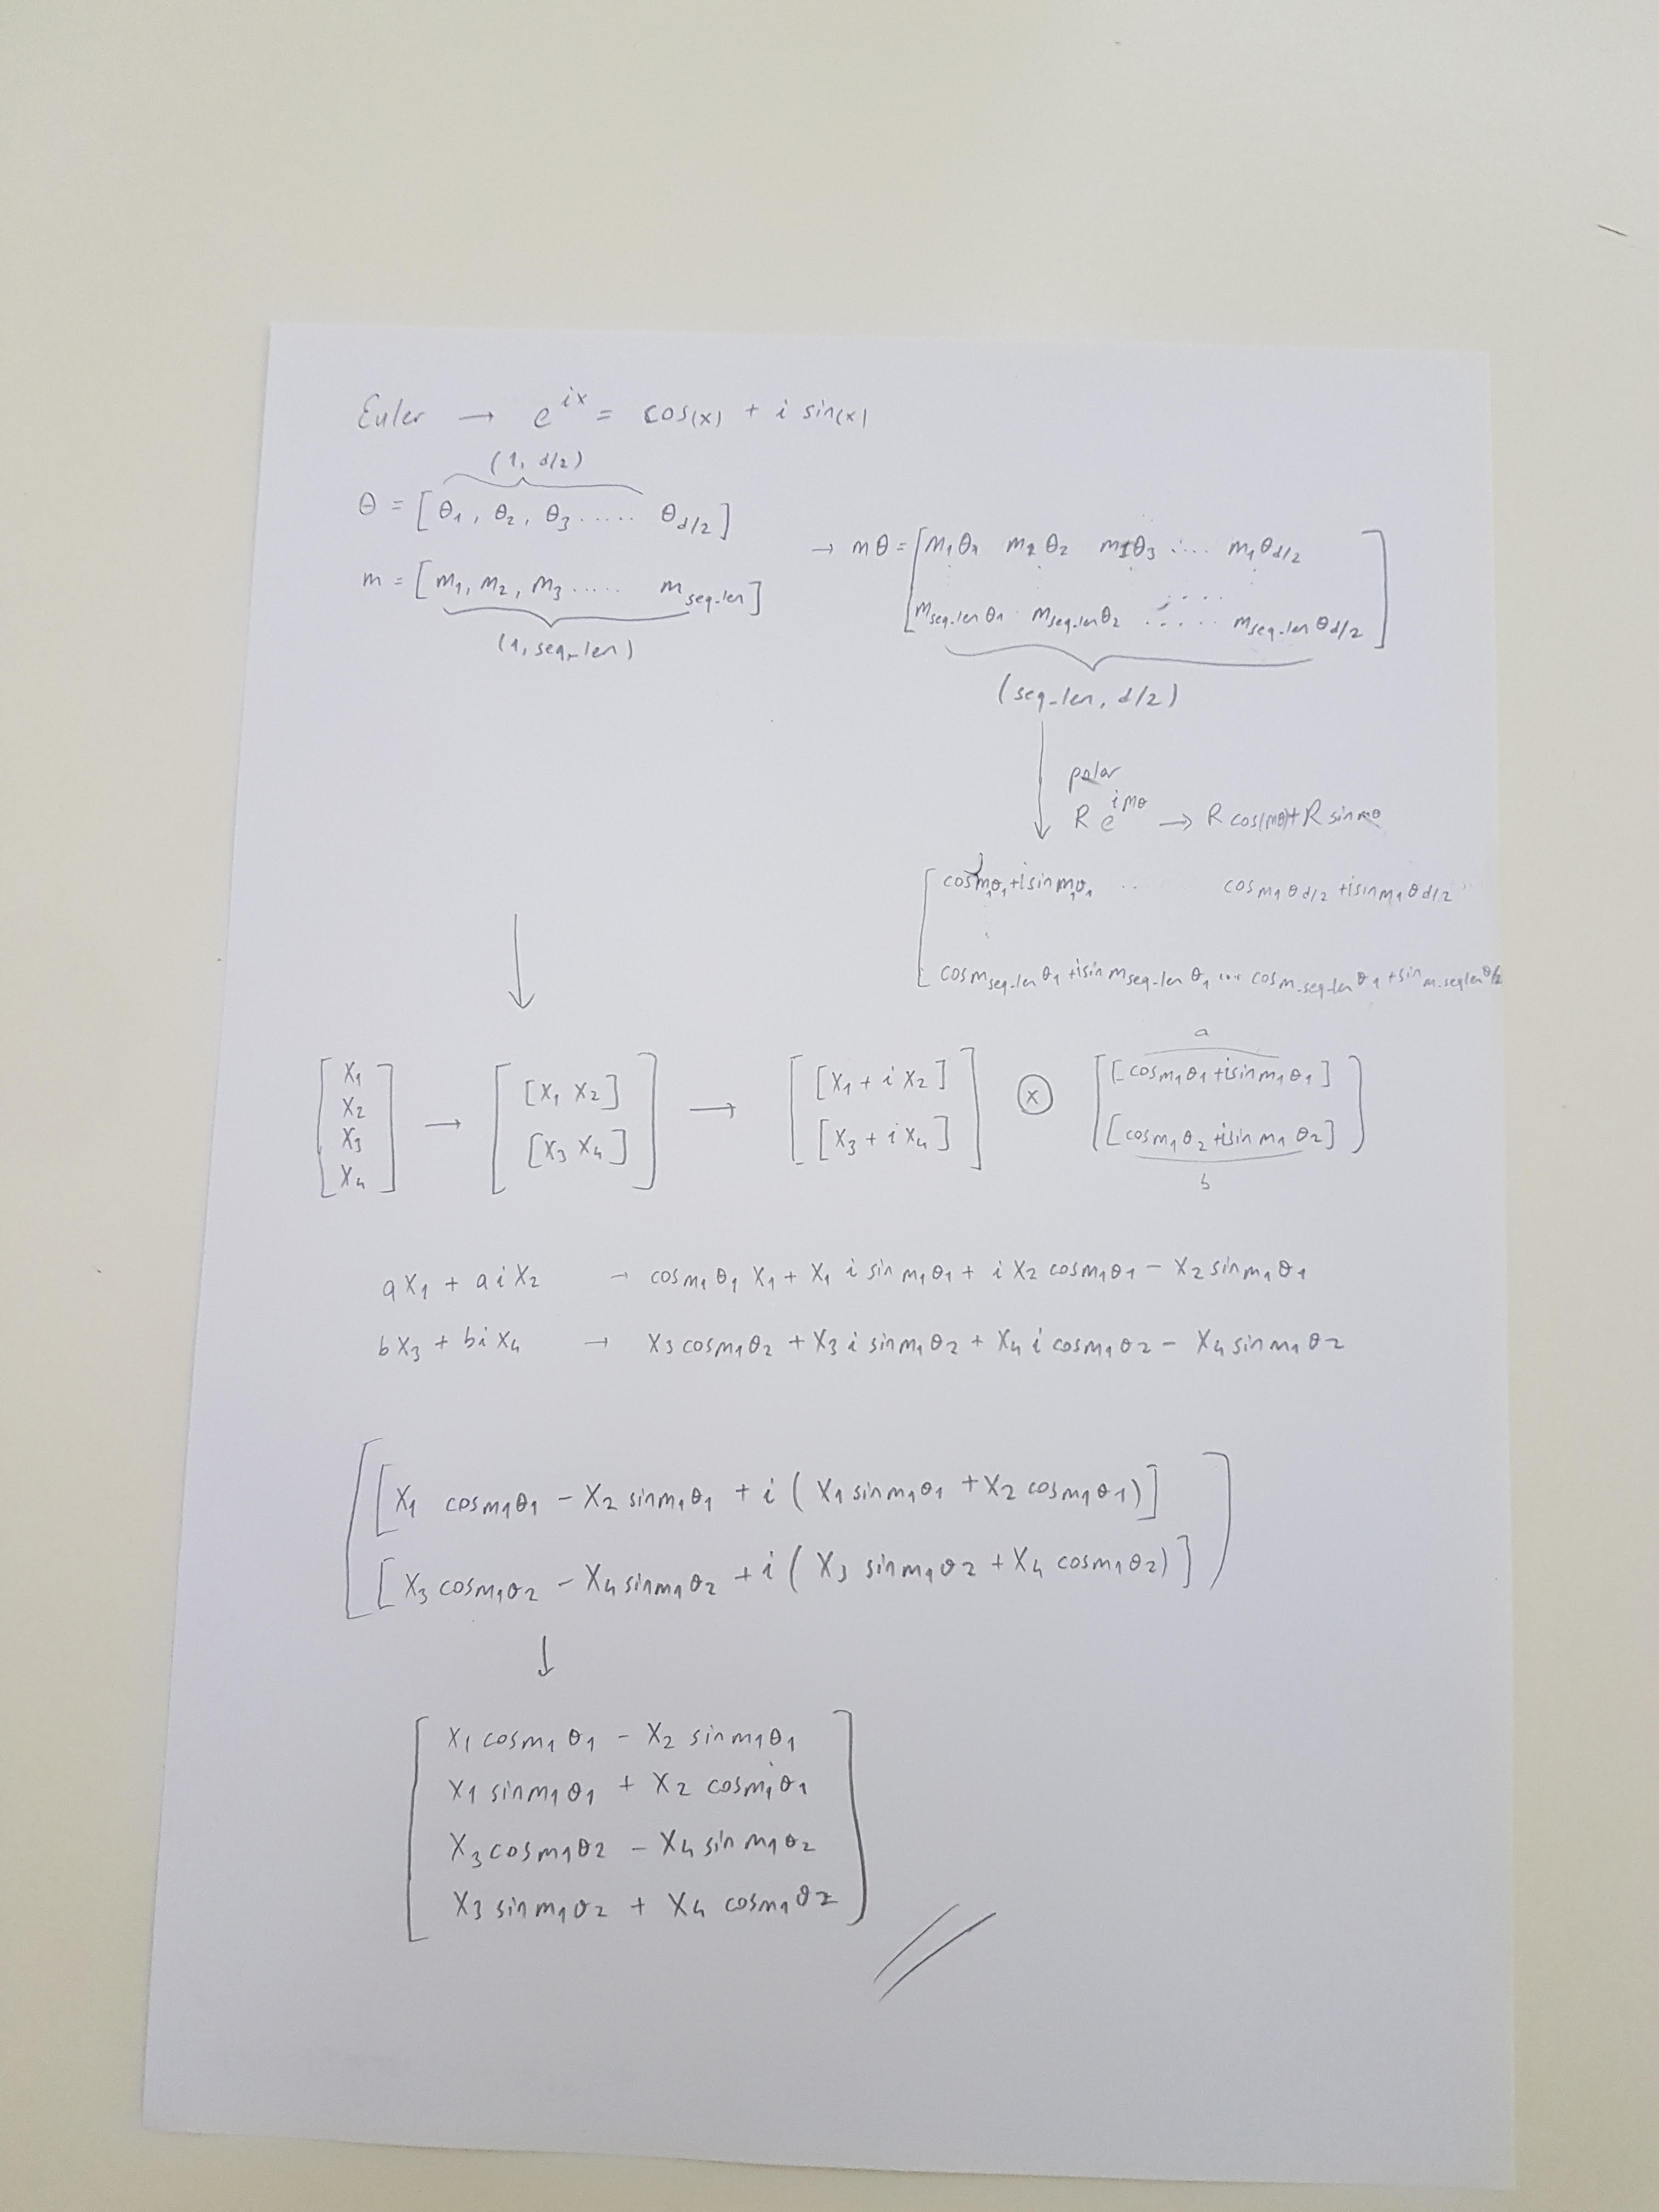

In [4]:
def compute_rope_params(head_dim:int, context_length:int=4096, theta_base:float=10000.0, dtype=torch.float32) -> tuple:
  assert head_dim % 2 == 0, "head_dim boyutu çift olmalıdır..."
  # (head_dim / 2)
  i = torch.arange(0, head_dim, 2, dtype = dtype).float()
  inv_freq = 1.0 / (theta_base ** (i / head_dim))
  # (seq_len, )
  pos = torch.arange(0, context_length, dtype = dtype)
  # (seq_len, head_dim // 2)
  angles = pos.unsqueeze(1) * inv_freq.unsqueeze(0)
  # (seq_len, head_dim // 2) -> (seq_len, head_dim)
  angles = torch.cat([angles, angles], dim = 1)
  cos = torch.cos(angles)
  sin = torch.sin(angles)
  return cos, sin

In [5]:
def apply_rope(x:torch.Tensor, cos:torch.Tensor, sin:torch.Tensor) -> torch.Tensor:
  # key ve query'e uygulanacağı için boyutlar bu şekilde olacaktır.
  batch_size, n_heads, seq_len, head_dim = x.shape
  assert head_dim % 2 == 0, "head_dim boyutu çift olmalıdır..."
  # İki yarıya bölelim (batch_size, n_heads, seq_len, head_dim // 2)
  x1 = x[..., :head_dim //2]
  x2 = x[..., head_dim //2:]
  #(seq_len, head_dim // 2) -> (1, 1, seq_len, head_dim // 2)
  cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)
  sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)
  # (batch_size, n_heads, seq_len, head_dim)
  rotated = torch.cat((-x2, x1), dim=-1)
  # (batch_size, n_heads, seq_len, head_dim)
  x_rotated = (x * cos) + (rotated * sin)
  return x_rotated.to(dtype=x.dtype)

## Grouped Multi Query Attention

Klasik Transformer mimarisinde, Query (Q), Key (K) ve Value (V) matrislerinin her biri aynı sayıda attention head’e sahiptir. Bu yapı güçlü bir temsil kapasitesi sağlasa da, özellikle büyük modellerde hesaplama maliyetini ve bellek kullanımını ciddi şekilde artırmaktadır. Bu da GPU'larda bottleneck'e sebep olmaktadır.

Bu nedenle, daha verimli bir yaklaşım olarak Multi-Query Attention (MQA) geliştirilmiştir. MQA’da Query tarafındaki head sayısı korunurken, Key ve Value matrislerindeki head sayısı azaltılmıştır. Böylece her Query head’i, paylaşılmış daha az sayıda Key ve Value setiyle etkileşir. Boyutların uyuşması için Key ve Value temsilcileri uygun şekilde kopyalanarak (replication) Query head’leriyle eşleştirilir. Bu yöntem, bellek kullanımını büyük oranda azaltırken hesaplama hızını da artırır. Ancak, farklı head’lerin aynı Key/Value bilgilerini paylaşması nedeniyle modelin temsil çeşitliliğinde bir miktar azalma gözlemlenir.

Daha dengeli bir çözüm olarak Grouped Query Attention (GQA) önerilmiştir. GQA’da Query head’leri belirli gruplara ayrılır ve her grup kendi Key ve Value setini paylaşır. Böylece MQA’ya kıyasla daha fazla bilgi çeşitliliği korunurken, klasik Multi-Head Attention’a göre bellek kullanımı ve hesaplama maliyeti önemli ölçüde azalır.

Özetle, attention head’leri modelin çıkarabileceği farklı özellikleri (feature’ları) temsil eder. Multi-Query Attention (MQA) maksimum verim sağlarken, Grouped-Query Attention (GQA) verimlilik ile temsil gücü arasında bir denge kurar.

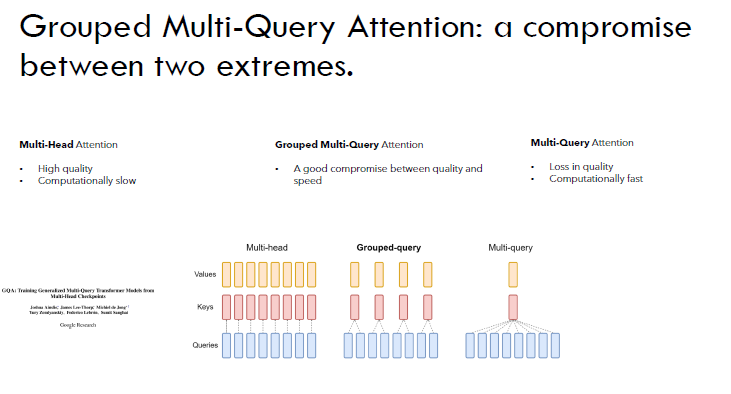

In [6]:
# Bu kodta normalden farklı olarak query scale edilir. Bu işlem yapılmazsa model çıktısı anlamsız oluyor.
class GroupedQueryAttention(nn.Module):
  def __init__(self, d_in:int, n_heads:int, n_kv_heads:int, head_dim:int, qk_norm:bool=True,
               query_pre_attn_scalar = None, dtype = None) -> None:
    super().__init__()
    assert d_in % n_heads == 0, "d_in boyutu head sayısına tam bölünmek zorundadır..."
    assert n_heads % n_kv_heads == 0, "n_heads boyutu n_kv_heads boyutuna tam bölünmek zorundadır..."

    self.d_in = d_in
    self.n_heads = n_heads
    self.n_kv_heads = n_kv_heads
    self.head_dim = head_dim
    self.qk_norm = qk_norm
    self.rep = self.n_heads // self.n_kv_heads

    self.W_query = nn.Linear(d_in, n_heads * head_dim, dtype = dtype, bias = False)
    self.W_key = nn.Linear(d_in, n_kv_heads * head_dim, dtype = dtype, bias = False)
    self.W_value = nn.Linear(d_in, n_kv_heads * head_dim, dtype = dtype, bias = False)
    self.proj = nn.Linear(n_heads * head_dim, d_in, dtype = dtype, bias = False)

    if self.qk_norm:
      self.q_norm = RMSNorm(self.head_dim)
      self.k_norm = RMSNorm(self.head_dim)
    else:
      self.q_norm = None
      self.k_norm = None

    if query_pre_attn_scalar is not None:
      self.scaling = (query_pre_attn_scalar) ** -0.5
    else:
      self.scaling = (head_dim) ** -0.5

  def forward(self, x:torch.Tensor, mask:torch.Tensor, cos:torch.Tensor, sin:torch.Tensor) -> torch.Tensor:
    batch_size, seq_len, d_in = x.shape
    # (batch_size, seq_len, d_in) -> (batch_size, seq_len, n_heads * head_dim)
    queries = self.W_query(x)
    # (batch_size, seq_len, d_in) -> (batch_size, seq_len, n_kv_heads * head_dim)
    keys = self.W_key(x) # Corrected from self.W_keys
    values = self.W_value(x) # Corrected from self.W_queries
    # (batch_size, seq_len, n_heads * head_dim) -> (batch_size, seq_len, n_heads, head_dim) -> (batch_size, n_heads, seq_len, head_dim)
    queries = queries.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
    # (batch_size, seq_len, n_kv_heads * head_dim) -> (batch_size, seq_len, n_kv_heads, head_dim) -> (batch_size, n_kv_heads, seq_len, head_dim)
    keys = keys.view(batch_size, seq_len, self.n_kv_heads, self.head_dim).transpose(1, 2)
    values = values.view(batch_size, seq_len, self.n_kv_heads, self.head_dim).transpose(1, 2)

    if self.qk_norm:
      queries = self.q_norm(queries)
      keys = self.k_norm(keys)

    keys = apply_rope(keys, cos, sin)
    queries = apply_rope(queries, cos, sin)
    # (batch_size, n_heads, seq_len, head_dim)
    keys = keys.repeat_interleave(self.rep, dim = 1)
    values = values.repeat_interleave(self.rep, dim = 1)
    # Query'i scale edeceğiz.
    queries = queries * self.scaling
    # (batch_size, n_heads, seq_len, head_dim) @ (batch_size, n_heads, head_dim, seq_len) -> (batch_size, n_heads, seq_len, seq_len)
    attn_scores = queries @ keys.transpose(2, 3)
    attn_scores = attn_scores.masked_fill(mask, -torch.inf)
    attn_probs = F.softmax(attn_scores, dim = -1)
    #(batch_size, n_heads, seq_len, seq_len) @ (batch_size, n_heads, seq_len, head_dim) -> (batch_size, n_heads, seq_len, head_dim) -> (batch_size, seq_len, n_heads, head_dim)
    attn_out = (attn_probs @ values).transpose(1, 2).reshape(batch_size, seq_len, self.n_heads * self.head_dim)
    attn_out = self.proj(attn_out)
    return attn_out

### Sliding Attention ###

Sliding attention, özellikle uzun dizilerde (long sequence) çalışan modellerde, her token’ın tüm diğer token’larla değil, sadece belirli bir pencere (window) içindeki token’larla etkileşime girmesine izin veren bir attention türüdür.

Bu pencere, tıpkı bir kayan pencere (sliding window) gibi dizinin üzerinde ilerler. Yani her konumdaki token sadece yakın komşularını görür. Causal Mask yaklaşımında O(n^2) işlem uygulanırken sliding attention'da O(n * w) işlem uygulanır. Bellek kullanımı klasik yaklaşıma göre daha düşüktür. Uzun dizilerde tercih edilir, yerel bağımlılıkları iyi yakalar. Ancak yapısından da anlaşılacağı gibi uzak bağımlılıkları yakalayamaz.

In [8]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg:dict, attn_type:str) -> None:
    super().__init__()
    self.attn_type = attn_type
    self.att = GroupedQueryAttention(
        d_in = cfg['emb_dim'],
        n_heads = cfg['n_heads'],
        n_kv_heads = cfg['n_kv_groups'],
        head_dim = cfg['head_dim'],
        qk_norm = cfg['qk_norm'],
        query_pre_attn_scalar=cfg["query_pre_attn_scalar"],
        dtype = cfg['dtype']
    )
    self.ff = FeedForward(cfg)
    self.input_layernorm = RMSNorm(cfg["emb_dim"])
    self.post_attention_layernorm = RMSNorm(cfg["emb_dim"])
    self.pre_feedforward_layernorm = RMSNorm(cfg["emb_dim"])
    self.post_feedforward_layernorm = RMSNorm(cfg["emb_dim"])

  def forward(
      self, x:torch.Tensor, mask_global:torch.Tensor, mask_local:torch.Tensor,
      cos_global:torch.Tensor, sin_global:torch.Tensor, cos_local:torch.Tensor,
      sin_local:torch.Tensor) -> torch.Tensor:

      shortcut = x
      x = self.input_layernorm(x)

      if self.attn_type == "sliding_attention":
        attn_mask = mask_local
        cos = cos_local
        sin = sin_local
      else:
        attn_mask = mask_global
        cos = cos_global
        sin = sin_global

      x_attn = self.att(x, attn_mask, cos, sin)
      x_attn = self.post_attention_layernorm(x_attn)
      x = shortcut + x_attn

      shortcut = x
      x_ffn = self.pre_feedforward_layernorm(x)
      x_ffn = self.ff(x_ffn)
      x_ffn = self.post_feedforward_layernorm(x_ffn)
      x = shortcut + x_ffn
      return x

In [ ]:
class Gemma3(nn.Module):
  def __init__(self, cfg:dict) -> None:
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'], dtype = cfg['dtype'])
    self.tr_blocks = nn.ModuleList([
        TransformerBlock(cfg, attn_type) for attn_type in cfg['layer_types']
    ])
    self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-6)
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])
    self.cfg = cfg

    cos_local, sin_local = compute_rope_params(
        head_dim=cfg["head_dim"],
        theta_base=cfg["rope_local_base"],
        context_length=cfg["context_length"],
        dtype=torch.float32,
    )
    cos_global, sin_global = compute_rope_params(
        head_dim=cfg["head_dim"],
        theta_base=cfg["rope_base"],
        context_length=cfg["context_length"],
        dtype=torch.float32,
    )
    self.register_buffer("cos_local", cos_local, persistent=False)
    self.register_buffer("sin_local", sin_local, persistent=False)
    self.register_buffer("cos_global", cos_global, persistent=False)
    self.register_buffer("sin_global", sin_global, persistent=False)

  def _create_masks(self, seq_len:int, device:str) -> tuple:
    # Öncelikli olarak seq_len x seq_len boyutlarında birlerden oluşan bir matris oluşturup üst üçgenini
    # 1 yaparız. Bu da attention matrisiyle oturduğunda o kısımlar True döneceği için o kısımları -inf atayabiliriz
    # ve softmaxten geçerek 0 olurlar.
    ones = torch.ones((seq_len, seq_len), dtype = torch.bool, device = device)

    # mask_global -> Bildiğimiz Causal Mask yapısı
    #     j:  0 1 2 3 4 5 6 7
    #  i
    #     0:  0 1 1 1 1 1 1 1
    #     1:  0 0 1 1 1 1 1 1
    #     2:  0 0 0 1 1 1 1 1
    #     3:  0 0 0 0 1 1 1 1
    #     4:  0 0 0 0 0 1 1 1
    #     5:  0 0 0 0 0 0 1 1
    #     6:  0 0 0 0 0 0 0 1
    #     7:  0 0 0 0 0 0 0 0

    mask_global = torch.triu(ones, diagonal=1)

    # sliding_windowdan itibaren kırpılan matrisin transpose'u
    # Örneğimizde sliding_window = 4 için
    #     j:  0 1 2 3 4 5 6 7
    #  i
    #     0:  0 0 0 0 0 0 0 0
    #     1:  0 0 0 0 0 0 0 0
    #     2:  0 0 0 0 0 0 0 0
    #     3:  0 0 0 0 0 0 0 0
    #     4:  1 0 0 0 0 0 0 0
    #     5:  1 1 0 0 0 0 0 0
    #     6:  1 1 1 0 0 0 0 0
    #     7:  1 1 1 1 0 0 0 0
    # Transpose almasaydık şekil şöyle olurdu:
    #     j:  0 1 2 3 4 5 6 7
    #  i
    #     0:  0 0 0 0 1 1 1 1
    #     1:  0 0 0 0 0 1 1 1
    #     2:  0 0 0 0 0 0 1 1
    #     3:  0 0 0 0 0 0 0 1
    #     4:  0 0 0 0 0 0 0 0
    #     5:  0 0 0 0 0 0 0 0
    #     6:  0 0 0 0 0 0 0 0
    #     7:  0 0 0 0 0 0 0 0 Ama biz transpose alarak şeklin yukarıdaki gibi olmasını sağladık. Daha sonra global_mask ile OR yapıp aşağıdaki şekli elde edeceğiz.
    far_past = torch.triu(ones, diagonal=self.cfg["sliding_window"]).T
    #     j:  0 1 2 3 4 5 6 7
    #  i
    #     0:  0 1 1 1 1 1 1 1
    #     1:  0 0 1 1 1 1 1 1
    #     2:  0 0 0 1 1 1 1 1
    #     3:  0 0 0 0 1 1 1 1
    #     4:  1 0 0 0 0 1 1 1
    #     5:  1 1 0 0 0 0 1 1
    #     6:  1 1 1 0 0 0 0 1
    #     7:  1 1 1 1 0 0 0 0   Bu sayede sliding window kadar kayma gerçekleştirilir.
    # Bu yöntem işlem bakımından Causal Mask' a göre avantajlıdır.
    # Causal Mask : O(N^2)
    # Sliding Window : O(N * sliding_window)
    mask_local = mask_global | far_past
    return mask_global, mask_local

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    batch_size, seq_len = x.shape
    # Bu işlem olmadan model çıktısı saçma oluyor.
    x = self.tok_emb(x) * (self.cfg['emb_dim'] ** 0.5)
    mask_global, mask_local = self._create_masks(seq_len, x.device)
    for block in self.tr_blocks:
      x = block(x, mask_global, mask_local, self.cos_global,
                self.sin_global, self.cos_local, self.sin_local)
    x = self.final_norm(x)
    logits = self.out_head(x.to(self.cfg["dtype"]))
    return logits

In [10]:
GEMMA3_CONFIG_270M = {
    #"vocab_size": 50257,
    "vocab_size": 262144,
    "context_length": 32_768,
    "emb_dim": 640,
    "n_heads": 4,
    "n_layers": 18,
    "hidden_dim": 2048,
    "head_dim": 256,
    "qk_norm": True,
    "n_kv_groups": 1,
    "rope_local_base": 10_000.0,
    "rope_base": 1_000_000.0,
    "sliding_window": 512,
      "layer_types": [
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention"
    ],
    "dtype": torch.bfloat16,
    "query_pre_attn_scalar": 256,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Gemma3(GEMMA3_CONFIG_270M).to(device)

In [11]:
model

Gemma3(
  (tok_emb): Embedding(262144, 640)
  (tr_blocks): ModuleList(
    (0-17): 18 x TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_features=640, out_features=1024, bias=False)
        (W_key): Linear(in_features=640, out_features=256, bias=False)
        (W_value): Linear(in_features=640, out_features=256, bias=False)
        (proj): Linear(in_features=1024, out_features=640, bias=False)
        (q_norm): RMSNorm()
        (k_norm): RMSNorm()
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=640, out_features=2048, bias=False)
        (fc2): Linear(in_features=640, out_features=2048, bias=False)
        (fc3): Linear(in_features=2048, out_features=640, bias=False)
      )
      (input_layernorm): RMSNorm()
      (post_attention_layernorm): RMSNorm()
      (pre_feedforward_layernorm): RMSNorm()
      (post_feedforward_layernorm): RMSNorm()
    )
  )
  (final_norm): RMSNorm()
  (out_head): Linear(in_features=640, out_features=26214

In [12]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad == True)
print(f"Toplam parametre sayısı: {total_params:,}")
print(f"Eğitilebilir parametre sayısı: {trainable_params:,}")

Toplam parametre sayısı: 435,870,336
Eğitilebilir parametre sayısı: 435,870,336


In [13]:
input_ids = torch.tensor([1, 2, 3], device=device).unsqueeze(0)
model(input_ids)

tensor([[[-0.1533,  0.3535, -0.7344,  ..., -0.2930, -1.5547,  0.1230],
         [-2.1719,  1.1875,  1.0469,  ..., -1.7266, -1.3359, -1.0781],
         [ 0.2324, -1.8594,  2.0156,  ...,  0.0972,  0.1060,  1.0234]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [14]:
# Bu kod Sebastian Rascka'nın çalışmasından alınmıştır. Buradaki amaç kendi modelimizdeki ağırlıkları seçip inen modeldeki karşılık gelen ağırlıklara eşleştirmektir.
def load_weights_into_gemma(model, param_config, params):

    def assign(left, right, tensor_name="unknown"):
        if left.shape != right.shape:
            raise ValueError(f"Shape mismatch in tensor '{tensor_name}'. Left: {left.shape}, Right: {right.shape}")

        with torch.no_grad():
            if isinstance(right, torch.Tensor):
                left.copy_(right)
            else:
                left.copy_(torch.as_tensor(right, dtype=left.dtype, device=left.device))

        return left

    # Embedding ağırlıkları
    if "model.embed_tokens.weight" in params:
        model.tok_emb.weight = assign(
            model.tok_emb.weight,
            params["model.embed_tokens.weight"],
            "model.embed_tokens.weight",
        )

    # Transformer katmanları iterasyonu
    for l in range(param_config["n_layers"]):
        block = model.tr_blocks[l]
        att = block.att

        att.W_query.weight = assign(
            att.W_query.weight,
            params[f"model.layers.{l}.self_attn.q_proj.weight"],
            f"model.layers.{l}.self_attn.q_proj.weight",
        )
        att.W_key.weight = assign(
            att.W_key.weight,
            params[f"model.layers.{l}.self_attn.k_proj.weight"],
            f"model.layers.{l}.self_attn.k_proj.weight",
        )
        att.W_value.weight = assign(
            att.W_value.weight,
            params[f"model.layers.{l}.self_attn.v_proj.weight"],
            f"model.layers.{l}.self_attn.v_proj.weight",
        )
        att.proj.weight = assign(
            att.proj.weight,
            params[f"model.layers.{l}.self_attn.o_proj.weight"],
            f"model.layers.{l}.self_attn.o_proj.weight",
        )
        att.q_norm.gamma = assign(
            att.q_norm.gamma,
            params[f"model.layers.{l}.self_attn.q_norm.weight"],
            f"model.layers.{l}.self_attn.q_norm.weight",
        )
        att.k_norm.gamma = assign(
            att.k_norm.gamma,
            params[f"model.layers.{l}.self_attn.k_norm.weight"],
            f"model.layers.{l}.self_attn.k_norm.weight",
        )
        block.ff.fc1.weight = assign(
            block.ff.fc1.weight,
            params[f"model.layers.{l}.mlp.gate_proj.weight"],
            f"model.layers.{l}.mlp.gate_proj.weight",
        )
        block.ff.fc2.weight = assign(
            block.ff.fc2.weight,
            params[f"model.layers.{l}.mlp.up_proj.weight"],
            f"model.layers.{l}.mlp.up_proj.weight",
        )
        block.ff.fc3.weight = assign(
            block.ff.fc3.weight,
            params[f"model.layers.{l}.mlp.down_proj.weight"],
            f"model.layers.{l}.mlp.down_proj.weight",
        )
        block.input_layernorm.gamma = assign(
            block.input_layernorm.gamma,
            params[f"model.layers.{l}.input_layernorm.weight"],
            f"model.layers.{l}.input_layernorm.weight",
        )
        block.post_attention_layernorm.gamma = assign(
            block.post_attention_layernorm.gamma,
            params[f"model.layers.{l}.post_attention_layernorm.weight"],
            f"model.layers.{l}.post_attention_layernorm.weight",
        )
        pre_key = f"model.layers.{l}.pre_feedforward_layernorm.weight"
        post_key = f"model.layers.{l}.post_feedforward_layernorm.weight"
        if pre_key in params:
            block.pre_feedforward_layernorm.gamma = assign(
                block.pre_feedforward_layernorm.gamma,
                params[pre_key],
                pre_key,
            )
        if post_key in params:
            block.post_feedforward_layernorm.gamma = assign(
                block.post_feedforward_layernorm.gamma,
                params[post_key],
                post_key,
            )

    if "model.norm.weight" in params:
        model.final_norm.gamma = assign(
            model.final_norm.gamma,
            params["model.norm.weight"],
            "model.norm.weight",
        )
    if "lm_head.weight" in params:
        model.out_head.weight = assign(
            model.out_head.weight,
            params["lm_head.weight"],
            "lm_head.weight",
        )
    else:
        model.out_head.weight = model.tok_emb.weight
        print("Model weight tying kullanıyor...")

In [15]:
from huggingface_hub import login
login()

In [16]:
# Gemma 3 model çeşitlerinden instruct modeli seçip .safetensors formatındaki dosyayo seçip index pathlerini de ilgili pathten alıyoruz.
USE_INSTRUCT_MODEL = True
CHOOSE_MODEL = "270m"

if USE_INSTRUCT_MODEL:
    repo_id = f"google/gemma-3-{CHOOSE_MODEL}-it"
else:
    repo_id = f"google/gemma-3-{CHOOSE_MODEL}"


local_dir = Path(repo_id).parts[-1]

if CHOOSE_MODEL == "270m":
    weights_file = hf_hub_download(
        repo_id=repo_id,
        filename="model.safetensors",
        local_dir=local_dir,
    )
    weights_dict = load_file(weights_file)
else:
    repo_dir = snapshot_download(repo_id=repo_id, local_dir=local_dir)
    index_path = os.path.join(repo_dir, "model.safetensors.index.json")
    with open(index_path, "r") as f:
        index = json.load(f)

    weights_dict = {}
    for filename in set(index["weight_map"].values()):
        shard_path = os.path.join(repo_dir, filename)
        shard = load_file(shard_path)
        weights_dict.update(shard)

load_weights_into_gemma(model, GEMMA3_CONFIG_270M, weights_dict)
model.to(device)
del weights_dict


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model weight tying kullanıyor...


In [17]:
from tokenizers import Tokenizer

class GemmaTokenizer:
    def __init__(self, tokenizer_file_path: str):
        tok_file = Path(tokenizer_file_path)
        self._tok = Tokenizer.from_file(str(tok_file))
        # Her tokenizer da görülen End Of Sentence tokenı, ve pad_tokenları atıyoruz.
        eos_token = "<end_of_turn>"
        self.pad_token_id = eos_token
        self.eos_token_id = eos_token

    def encode(self, text: str) -> list[int]:
        return self._tok.encode(text).ids

    def decode(self, ids: list[int]) -> str:
        return self._tok.decode(ids, skip_special_tokens=False)


def apply_chat_template(user_text):
    return f"<start_of_turn>user\n{user_text}<end_of_turn>\n<start_of_turn>model\n"

In [18]:
# Tokenizer ı indirip kendi tokenizer sınıfımıza yolluyoruz.
tokenizer_file_path = os.path.join(local_dir, "tokenizer.json")
if not os.path.exists(tokenizer_file_path):
    try:
        tokenizer_file_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.json", local_dir=local_dir)
    except Exception as e:
        print(f"Warning: failed to download tokenizer.json: {e}")
        tokenizer_file_path = "tokenizer.json"

tokenizer = GemmaTokenizer(tokenizer_file_path=tokenizer_file_path)

In [19]:
#Promptumuzu encode ederek sınıf performansını test ediyoruz.
prompt = "Give me a short introduction to large language models."
prompt = apply_chat_template("Give me a short introduction to large language models.")


input_token_ids = tokenizer.encode(prompt)
text = tokenizer.decode(input_token_ids)
text

'<bos><start_of_turn>user\nGive me a short introduction to large language models.<end_of_turn>\n<start_of_turn>model\n'

In [20]:
def generate_text_basic_stream(model, token_ids, max_new_tokens, eos_token_id=None):
    # Ağırlıklarımız elimizde train mode a bu yüzden gerek yok. Bundan dolayı modeli eval mode a alırız.
    model.eval()
    with torch.no_grad():
        # max gidebileceği token kadar gider ilgili token ı modele yollayıp çıkan en yüksek olasılığın tokenını alır normalde ekleriz
        # ama burada stream efekti vermek için token gelir gelmez yield ile basarız. eos token gelince işimiz biter ve çıkarız.
        for _ in range(max_new_tokens):
            out = model(token_ids)[:, -1]
            next_token = torch.argmax(out, dim=-1, keepdim=True)

            if (eos_token_id is not None
                   and torch.all(next_token == eos_token_id)):
               break

            yield next_token

            token_ids = torch.cat([token_ids, next_token], dim=1)

In [21]:
input_token_ids_tensor = torch.tensor(input_token_ids, device=device).unsqueeze(0)

for token in generate_text_basic_stream(
    model=model,
    token_ids=input_token_ids_tensor,
    max_new_tokens=500,
    eos_token_id=tokenizer.encode("<end_of_turn>")[-1]
):
    token_id = token.squeeze(0).tolist()
    print(
        tokenizer.decode(token_id),
        end="",
        flush=True
    )

Large language models (LLMs) are sophisticated artificial intelligence systems that can understand, generate, and manipulate human language. They are trained on massive amounts of text data to learn patterns and relationships within language, enabling them to perform a wide range of tasks, from writing articles and answering questions to translating languages and summarizing information.
